In [221]:
#conda install -c anaconda py-xgboost

In [222]:
#pip install pandas_datareader

In [2]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
import pandas_datareader as pdr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
#### Input params ##################
#stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [4]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [5]:
df=pdr.get_data_yahoo('^GSPC',start = '2015-02-28', end = '2020-02-28')

In [6]:
df=df.reset_index()
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-03-02,2117.520020,2104.500000,2105.229980,2117.389893,3409490000,2117.389893
1,2015-03-03,2115.760010,2098.260010,2115.760010,2107.780029,3262300000,2107.780029
2,2015-03-04,2107.719971,2094.489990,2107.719971,2098.530029,3421110000,2098.530029
3,2015-03-05,2104.250000,2095.219971,2098.540039,2101.040039,3103030000,2101.040039
4,2015-03-06,2100.909912,2067.270020,2100.909912,2071.260010,3853570000,2071.260010
...,...,...,...,...,...,...,...
1254,2020-02-24,3259.810059,3214.649902,3257.610107,3225.889893,4842960000,3225.889893
1255,2020-02-25,3246.989990,3118.770020,3238.939941,3128.209961,5591510000,3128.209961
1256,2020-02-26,3182.510010,3108.989990,3139.899902,3116.389893,5478110000,3116.389893
1257,2020-02-27,3097.070068,2977.389893,3062.540039,2978.760010,7058840000,2978.760010


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256 entries, 3 to 1258
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1256 non-null   datetime64[ns]
 1   volume           1256 non-null   int64         
 2   adj_close        1256 non-null   float64       
 3   month            1256 non-null   int64         
 4   range_hl         1256 non-null   float64       
 5   range_oc         1256 non-null   float64       
 6   order_day        1256 non-null   int64         
 7   adj_close_lag_1  1256 non-null   float64       
 8   range_hl_lag_1   1256 non-null   float64       
 9   range_oc_lag_1   1256 non-null   float64       
 10  volume_lag_1     1256 non-null   float64       
 11  adj_close_lag_2  1256 non-null   float64       
 12  range_hl_lag_2   1256 non-null   float64       
 13  range_oc_lag_2   1256 non-null   float64       
 14  volume_lag_2     1256 non-null   float64

In [7]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,high,low,open,close,volume,adj_close,month
0,2015-03-02,2117.520020,2104.500000,2105.229980,2117.389893,3409490000,2117.389893,3
1,2015-03-03,2115.760010,2098.260010,2115.760010,2107.780029,3262300000,2107.780029,3
2,2015-03-04,2107.719971,2094.489990,2107.719971,2098.530029,3421110000,2098.530029,3
3,2015-03-05,2104.250000,2095.219971,2098.540039,2101.040039,3103030000,2101.040039,3
4,2015-03-06,2100.909912,2067.270020,2100.909912,2071.260010,3853570000,2071.260010,3


Text(0, 0.5, 'USD')

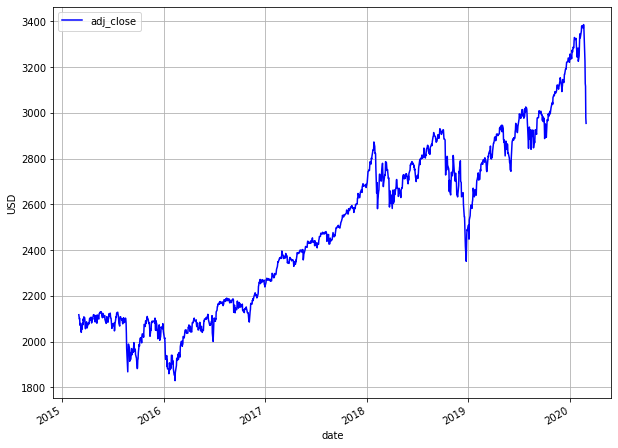

In [8]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [9]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,volume,adj_close,month,range_hl,range_oc
0,2015-03-02,3409490000,2117.389893,3,13.020020,-12.159912
1,2015-03-03,3262300000,2107.780029,3,17.500000,7.979980
2,2015-03-04,3421110000,2098.530029,3,13.229980,9.189941
3,2015-03-05,3103030000,2101.040039,3,9.030029,-2.500000
4,2015-03-06,3853570000,2071.260010,3,33.639893,29.649902


Now we use lags up to N number of days to use as features.

In [10]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [11]:
df.head() 

,date,volume,adj_close,month,range_hl,range_oc,order_day
0,2015-03-02,3409490000,2117.389893,3,13.020020,-12.159912,0
1,2015-03-03,3262300000,2107.780029,3,17.500000,7.979980,1
2,2015-03-04,3421110000,2098.530029,3,13.229980,9.189941,2
3,2015-03-05,3103030000,2101.040039,3,9.030029,-2.500000,3
4,2015-03-06,3853570000,2071.260010,3,33.639893,29.649902,4


In [12]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2015-03-05,3103030000,2101.040039,3,9.030029,-2.500000,3,2098.530029,13.229980,9.189941,3.421110e+09,2107.780029,17.500000,7.979980,3.262300e+09,2117.389893,13.020020,-12.159912,3.409490e+09
4,2015-03-06,3853570000,2071.260010,3,33.639893,29.649902,4,2101.040039,9.030029,-2.500000,3.103030e+09,2098.530029,13.229980,9.189941,3.421110e+09,2107.780029,17.500000,7.979980,3.262300e+09
5,2015-03-09,3349090000,2079.429932,3,11.280029,-7.179932,5,2071.260010,33.639893,29.649902,3.853570e+09,2101.040039,9.030029,-2.500000,3.103030e+09,2098.530029,13.229980,9.189941,3.421110e+09
6,2015-03-10,3668900000,2044.160034,3,31.979858,31.979858,6,2079.429932,11.280029,-7.179932,3.349090e+09,2071.260010,33.639893,29.649902,3.853570e+09,2101.040039,9.030029,-2.500000,3.103030e+09
7,2015-03-11,3406570000,2040.239990,3,10.390137,4.449951,7,2044.160034,31.979858,31.979858,3.668900e+09,2079.429932,11.280029,-7.179932,3.349090e+09,2071.260010,33.639893,29.649902,3.853570e+09


  0%|<bar/>| 0/3 [00:00<?, ?it/s]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256 entries, 3 to 1258
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1256 non-null   datetime64[ns]
 1   volume           1256 non-null   int64         
 2   adj_close        1256 non-null   float64       
 3   month            1256 non-null   int64         
 4   range_hl         1256 non-null   float64       
 5   range_oc         1256 non-null   float64       
 6   order_day        1256 non-null   int64         
 7   adj_close_lag_1  1256 non-null   float64       
 8   range_hl_lag_1   1256 non-null   float64       
 9   range_oc_lag_1   1256 non-null   float64       
 10  volume_lag_1     1256 non-null   float64       
 11  adj_close_lag_2  1256 non-null   float64       
 12  range_hl_lag_2   1256 non-null   float64       
 13  range_oc_lag_2   1256 non-null   float64       
 14  volume_lag_2     1256 non-null   float64

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [17]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2015-03-05,3103030000,2101.040039,3,9.030029,-2.500000,3,2098.530029,13.229980,9.189941,...,-12.159912,3.409490e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-03-06,3853570000,2071.260010,3,33.639893,29.649902,4,2101.040039,9.030029,-2.500000,...,7.979980,3.262300e+09,2101.040039,NaN,9.030029,NaN,-2.500000,NaN,3.103030e+09,NaN
5,2015-03-09,3349090000,2079.429932,3,11.280029,-7.179932,5,2071.260010,33.639893,29.649902,...,9.189941,3.421110e+09,2086.150024,21.057661,21.334961,17.401801,13.574951,22.733414,3.478300e+09,5.307119e+08
6,2015-03-10,3668900000,2044.160034,3,31.979858,31.979858,6,2079.429932,11.280029,-7.179932,...,-2.500000,3.103030e+09,2083.909993,15.387194,17.983317,13.605583,6.656657,20.049749,3.435230e+09,3.826129e+08
7,2015-03-11,3406570000,2040.239990,3,10.390137,4.449951,7,2044.160034,31.979858,31.979858,...,29.649902,3.853570e+09,2064.949992,18.462223,25.633260,12.457943,18.149943,21.967228,3.623853e+09,2.552389e+08


# Split into train, dev and test set

In [18]:
df[df['date']=='2019-12-26'].index.values

array([1215])

In [19]:
# Get sizes of each of the datasets
#num_cv = int(cv_size*len(df))
#num_test = int(test_size*len(df))
#num_train = len(df) - num_cv - num_test
#print("num_train = " + str(num_train))
#print("num_cv = " + str(num_cv))
#print("num_test = " + str(num_test))

num_cut1=df[df['date']=='2019-6-3'].index.values[0]
num_cut2=df[df['date']=='2019-12-26'].index.values[0]
# Split into train, cv, and test
train = df[:num_cut1]
cv = df[num_cut1:num_cut2]
train_cv = df[:num_cut2]
test = df[num_cut2:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (1071, 27)
cv.shape = (144, 27)
train_cv.shape = (1215, 27)
test.shape = (41, 27)


In [20]:
train

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2015-03-05,3103030000,2101.040039,3,9.030029,-2.500000,3,2098.530029,13.229980,9.189941,...,-12.159912,3.409490e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-03-06,3853570000,2071.260010,3,33.639893,29.649902,4,2101.040039,9.030029,-2.500000,...,7.979980,3.262300e+09,2101.040039,NaN,9.030029,NaN,-2.500000,NaN,3.103030e+09,NaN
5,2015-03-09,3349090000,2079.429932,3,11.280029,-7.179932,5,2071.260010,33.639893,29.649902,...,9.189941,3.421110e+09,2086.150024,21.057661,21.334961,17.401801,13.574951,22.733414,3.478300e+09,5.307119e+08
6,2015-03-10,3668900000,2044.160034,3,31.979858,31.979858,6,2079.429932,11.280029,-7.179932,...,-2.500000,3.103030e+09,2083.909993,15.387194,17.983317,13.605583,6.656657,20.049749,3.435230e+09,3.826129e+08
7,2015-03-11,3406570000,2040.239990,3,10.390137,4.449951,7,2044.160034,31.979858,31.979858,...,29.649902,3.853570e+09,2064.949992,18.462223,25.633260,12.457943,18.149943,21.967228,3.623853e+09,2.552389e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,2019-05-30,3273790000,2788.860107,5,22.260010,-1.920166,1069,2783.020020,25.969971,7.229980,...,6.349854,2.887390e+09,2803.823324,21.555795,28.690023,9.187020,13.739990,12.045921,3.569617e+09,6.272647e+08
1070,2019-05-31,3981020000,2752.060059,5,18.459961,14.089844,1070,2788.860107,22.260010,-1.920166,...,27.640137,4.121410e+09,2791.423340,9.936076,29.053304,8.752244,10.983317,15.133358,3.698417e+09,4.238124e+08
1071,2019-06-03,3943810000,2744.449951,6,34.260010,7.080078,1071,2752.060059,18.459961,14.089844,...,7.229980,3.700050e+09,2774.646729,19.777384,22.229980,3.755095,6.466553,8.032261,3.651620e+09,3.560936e+08
1072,2019-06-04,3810430000,2803.270020,6,41.850098,-40.630127,1072,2744.449951,34.260010,7.080078,...,-1.920166,3.273790e+09,2761.790039,23.750155,24.993327,8.247039,6.416585,8.025601,3.732873e+09,3.980129e+08


# Scale the train, dev and test set

In [21]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 2.39304258e+03  2.39236319e+03  2.20364885e+01 -1.85844129e-01
  3.64067819e+09  2.39171381e+03  2.20137527e+01 -1.40456541e-01
  3.64016640e+09  2.39112832e+03  2.19939208e+01 -1.58421051e-01
  3.63966750e+09]
scaler.var_ = [9.73017729e+04 9.72071523e+04 2.60957833e+02 3.17783314e+02
 4.60825252e+17 9.71246981e+04 2.60609978e+02 3.16316212e+02
 4.60931764e+17 9.70784457e+04 2.60545081e+02 3.16402100e+02
 4.60895112e+17]
train_scaled.shape = (1071, 13)
train_scaled.shape = (1071, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.936109,-0.942436,-0.545153,0.525947,-0.323446,-0.911071,-0.279603,0.456582,-0.556570,-0.878566,-0.555955,-0.674707,-0.339048,2015-03-05,3
1,-1.031578,-0.934385,-0.805145,-0.129816,-0.792009,-0.940752,-0.544109,0.524613,-0.322654,-0.909409,-0.278409,0.457530,-0.555857,2015-03-06,3
2,-1.005387,-1.029901,0.718291,1.673676,0.313611,-0.932698,-0.804273,-0.132668,-0.791164,-0.939097,-0.542948,0.525552,-0.321932,2015-03-09,3
3,-1.118456,-1.003697,-0.665862,-0.392343,-0.429538,-1.028254,0.720178,1.675001,0.314328,-0.931041,-0.803145,-0.131640,-0.790460,2015-03-10,3
4,-1.131023,-1.116821,0.615529,1.804378,0.041574,-1.002039,-0.664898,-0.395803,-0.428735,-1.026620,0.721497,1.675783,0.315076,2015-03-11,3


In [239]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 2.46563387e+03  2.46470979e+03  2.21921804e+01 -2.12829339e-01
  3.62314905e+09  2.46377791e+03  2.21954233e+01 -2.12195578e-01
  3.62383517e+09  2.46285402e+03  2.21955385e+01 -2.11742863e-01
  3.62486300e+09]
scaler_train_cv.var_ = [1.26096011e+05 1.25736103e+05 2.54744978e+02 3.14230381e+02
 4.59493990e+17 1.25345352e+05 2.54701757e+02 3.14240277e+02
 4.58426385e+17 1.24947464e+05 2.54699628e+02 3.14229210e+02
 4.56701148e+17]
train_cv_scaled.shape = (1215, 13)
train_cv_scaled.shape = (1215, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.026736,-1.032677,-0.561516,0.530434,-0.298054,-1.005526,-0.294211,0.462134,-0.533969,-0.977326,-0.574932,-0.674028,-0.318695,2015-03-05,3
1,-1.110599,-1.025598,-0.824658,-0.129025,-0.767296,-1.031653,-0.561766,0.530390,-0.299415,-1.004512,-0.294219,0.462117,-0.536497,2015-03-06,3
2,-1.087592,-1.109582,0.717242,1.684634,0.339924,-1.024563,-0.824932,-0.129059,-0.769202,-1.030680,-0.561776,0.530374,-0.301500,2015-03-09,3
3,-1.186916,-1.086541,-0.683687,-0.393032,-0.404300,-1.108678,0.717100,1.684571,0.339306,-1.023580,-0.824942,-0.129087,-0.772175,2015-03-10,3
4,-1.197955,-1.186007,0.613235,1.816072,0.067493,-1.085602,-0.683949,-0.393062,-0.405784,-1.107828,0.717096,1.684575,0.338426,2015-03-11,3


In [240]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1074,2019-06-06,0.827106,0.284245,-1.111351,-1.006600,0.993267,0.013333,0.238316,-1.097628,0.859312,-1.089242,0.212712,0.876530
1075,2019-06-07,0.951085,0.091536,-1.042621,-0.363926,-0.767072,1.130999,0.363846,0.767136,-1.130981,-0.901707,-0.173802,1.075508
1076,2019-06-10,1.075838,-0.174697,-0.901140,0.947818,0.097257,-1.045075,-0.959464,-0.076659,1.036123,-1.023194,0.048125,0.975069
1077,2019-06-11,0.852757,0.247865,-1.100622,-1.135908,0.747634,0.388274,1.111187,-0.827527,-0.283660,-0.629105,-0.524000,1.153105
1078,2019-06-12,0.508295,0.643754,-1.152049,0.576015,-1.154700,0.578685,0.990036,0.019638,-1.009674,1.154227,-0.605754,-0.548473


In [24]:
test  

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
1218,2019-12-31,2893810000,3230.780029,12,19.689941,-15.600098,1218,3221.290039,24.349854,18.800049,...,-12.709961,2.160680e+09,3233.739990,10.782115,16.929932,6.434821,4.433350,15.937451,2.534213e+09,4.359937e+08
1219,2020-01-02,3458250000,3257.850098,1,22.609863,-13.180176,1219,3230.780029,19.689941,-15.600098,...,7.209961,2.428670e+09,3230.696696,9.365268,19.199870,5.411688,3.469971,17.502376,2.778590e+09,3.088719e+08
1220,2020-01-03,3461290000,3234.850098,1,23.809814,-8.489990,1220,3257.850098,22.609863,-13.180176,...,18.800049,3.013290e+09,3236.640055,18.971410,22.216553,2.354722,-3.326742,19.200525,3.121783e+09,2.974495e+08
1221,2020-01-06,3674070000,3246.280029,1,32.200195,-28.729980,1221,3234.850098,23.809814,-8.489990,...,-15.600098,2.893810e+09,3241.160075,14.596541,22.036540,2.118930,-12.423421,3.614957,3.271117e+09,3.267607e+08
1222,2020-01-07,3420380000,3237.179932,1,12.479980,4.680176,1222,3246.280029,32.200195,-28.729980,...,-13.180176,3.458250e+09,3246.326742,11.500071,26.206624,5.225145,-16.800049,10.594428,3.531203e+09,1.237355e+08
1223,2020-01-08,3720890000,3253.050049,1,30.400146,-14.459961,1223,3237.179932,12.479980,4.680176,...,-8.489990,3.461290e+09,3239.436686,6.039912,22.829997,9.896552,-10.846598,16.829285,3.518580e+09,1.362030e+08
1224,2020-01-09,3638390000,3274.699951,1,11.910156,-8.669922,1224,3253.050049,30.400146,-14.459961,...,-28.729980,3.674070e+09,3245.503337,7.963516,25.026774,10.903053,-12.836589,16.764133,3.605113e+09,1.616874e+08
1225,2020-01-10,3212970000,3265.350098,1,22.129883,16.459961,1225,3274.699951,11.910156,-8.669922,...,4.680176,3.420380e+09,3254.976644,18.834059,18.263428,10.514568,-6.149902,9.815757,3.593220e+09,1.552637e+08
1226,2020-01-13,3456380000,3288.129883,1,19.699951,-17.000000,1226,3265.350098,22.129883,16.459961,...,-14.459961,3.720890e+09,3264.366699,10.858401,21.480062,9.262107,-2.223307,16.437138,3.524083e+09,2.725714e+08
1227,2020-01-14,3665130000,3283.149902,1,17.060059,2.200195,1227,3288.129883,19.699951,-17.000000,...,-8.669922,3.638390e+09,3276.059977,11.450629,17.913330,5.338981,-3.069987,17.418717,3.435913e+09,2.134472e+08


In [241]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1218,2019-12-31,-1.154685,0.582449,0.572237,1.153089,-0.523731,-0.629358,0.901443,0.174219,-1.075662,1.098816,-0.242075,-0.856740
1219,2020-01-02,0.008898,-1.004419,0.995521,0.090558,0.951641,-1.042199,-1.089570,0.875886,0.213685,0.373035,0.759862,-1.132897
1220,2020-01-03,1.118000,-0.308887,-0.809113,0.167031,-1.072998,0.905967,-0.513186,-0.639220,1.152406,1.131172,-0.766427,-0.364745
1221,2020-01-06,-0.432293,1.143423,-0.711131,0.836873,0.270572,-1.107445,1.088099,-0.209340,-0.878759,0.581996,0.572692,-1.154688
1222,2020-01-07,-0.004062,-0.997963,1.002025,1.147063,-0.458707,-0.688356,-1.126057,0.784380,0.341677,1.154613,-0.565022,-0.589591


# Split into X and y

In [242]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"
 

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1071, 12)
y_train.shape = (1071,)
X_cv.shape = (144, 12)
y_cv.shape = (144,)
X_train_cv.shape = (1215, 12)
y_train_cv.shape = (1215,)
X_sample.shape = (41, 12)
y_sample.shape = (41,)


In [243]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1071, 12)
y_train_scaled.shape = (1071,)
X_cv_scaled.shape = (144, 12)
X_train_cv_scaled.shape = (1215, 12)
y_train_cv_scaled.shape = (1215,)
X_sample_scaled.shape = (41, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

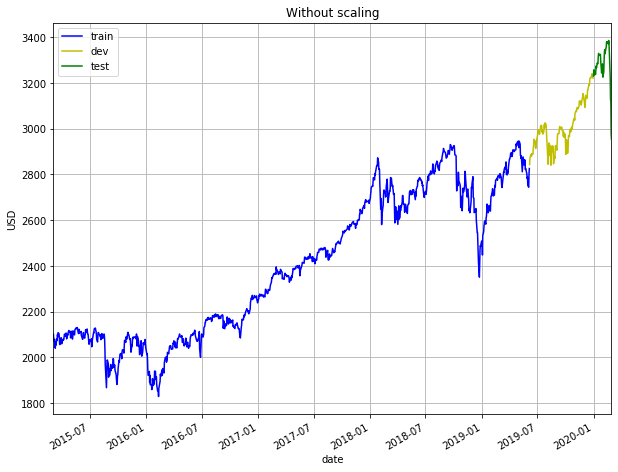

In [244]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

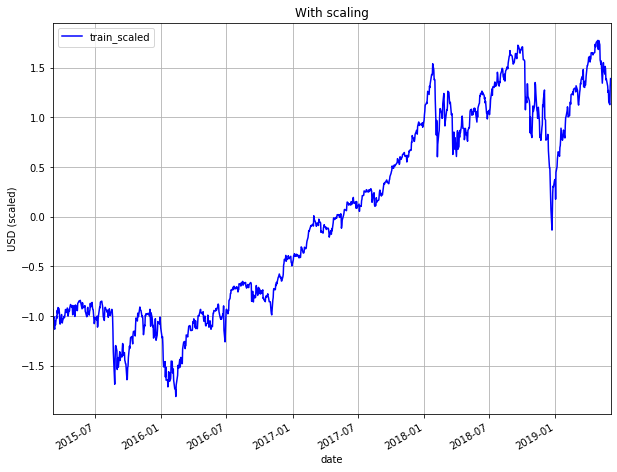

In [245]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [246]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma,
                     objective ='reg:linear')

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

[21:41:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

# Predict on train set

In [247]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 14.344
MAPE on train set = 0.440%


Text(0.5, 1.0, 'Without scaling')

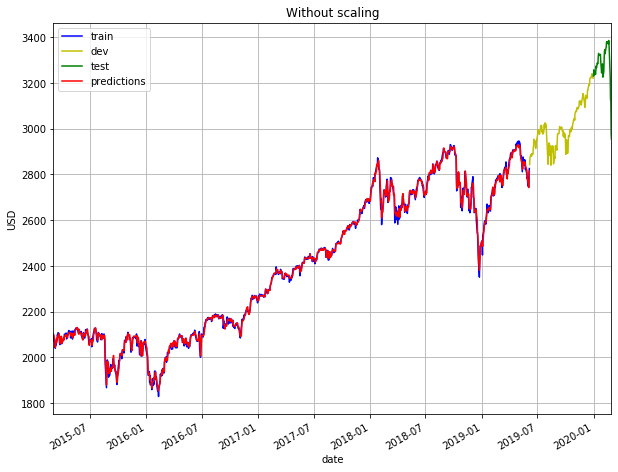

In [248]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [249]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 22.882
MAPE on dev set = 0.554%


Text(0, 0.5, 'USD')

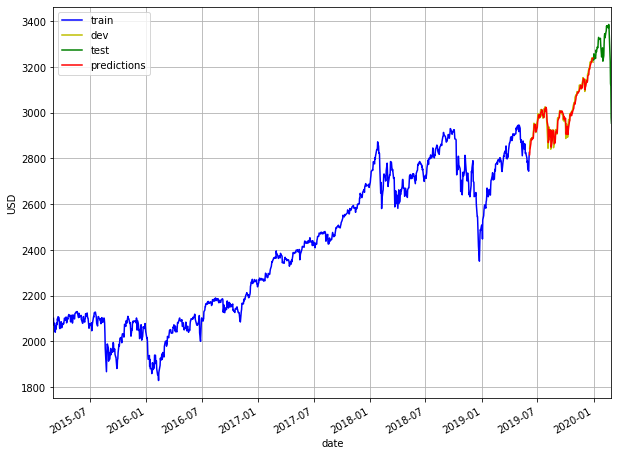

In [250]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

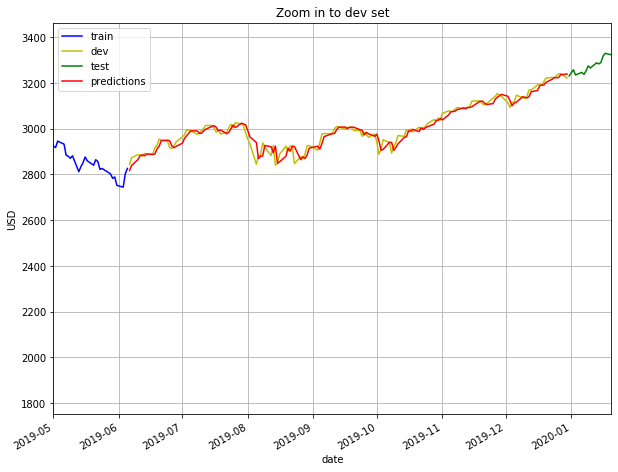

In [251]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 5, 1), date(2020, 1, 20)])
ax.set_title("Zoom in to dev set")

In [252]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_hl_lag_2', 0.0005725006),
 ('range_oc_lag_1', 0.0005744569),
 ('range_hl_lag_1', 0.00062038633),
 ('range_hl_lag_3', 0.00063035276),
 ('range_oc_lag_3', 0.0006600614),
 ('range_oc_lag_2', 0.00067581824),
 ('volume_lag_1', 0.0010993918),
 ('adj_close_lag_2', 0.106422566),
 ('adj_close_lag_3', 0.24367872),
 ('adj_close_lag_1', 0.64414173)]

Importance features dominated by adj_close and volume

# Tuning N (no. of days to use as features)

In [253]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


Use N = 3 for lowest RMSE and MAPE

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [254]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[21:41:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:42:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,n_estimators,max_depth,rmse,mape_pct
0,10,2,22.845802,0.539226
1,10,3,23.010287,0.543050
2,10,4,22.861927,0.537411
3,10,5,22.841029,0.537452
4,10,6,22.911579,0.540368
...,...,...,...,...
235,300,5,22.614237,0.549401
236,300,6,22.651315,0.551562
237,300,7,22.655197,0.552221
238,300,8,22.669108,0.552750


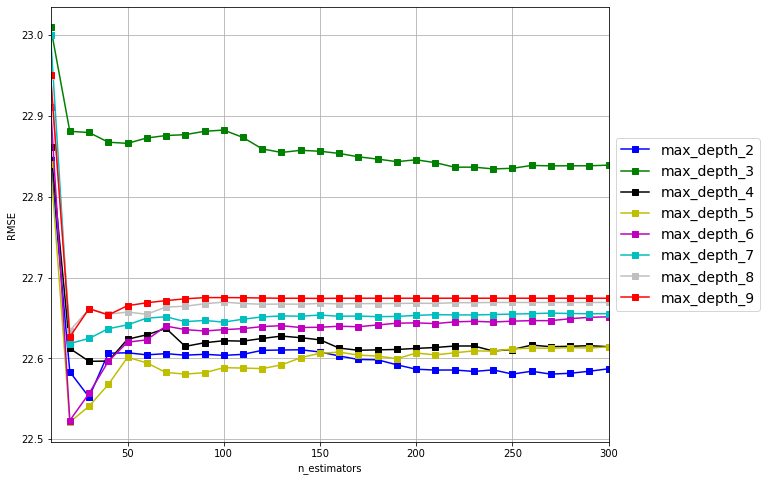

In [255]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [256]:
temp

,n_estimators,max_depth,rmse,mape_pct
7,10,9,22.950060,0.540883
15,20,9,22.626568,0.546538
23,30,9,22.661505,0.550624
31,40,9,22.653648,0.551349
39,50,9,22.665129,0.551652
47,60,9,22.668748,0.551798
55,70,9,22.671404,0.551949
63,80,9,22.673623,0.551987
71,90,9,22.675131,0.552049
79,100,9,22.675163,0.552069


In [257]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 22.521
optimum params = 


(20, 5)

In [258]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.537%
optimum params = 


(10, 4)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [259]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[21:43:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,27.163789,0.645806
1,0.001,6,27.163789,0.645806
2,0.001,7,27.163894,0.645810
3,0.001,8,27.163894,0.645810
4,0.001,9,27.163894,0.645810
...,...,...,...,...
107,0.300,16,23.357116,0.566312
108,0.300,17,23.367362,0.566053
109,0.300,18,23.220600,0.560124
110,0.300,19,23.309282,0.561729


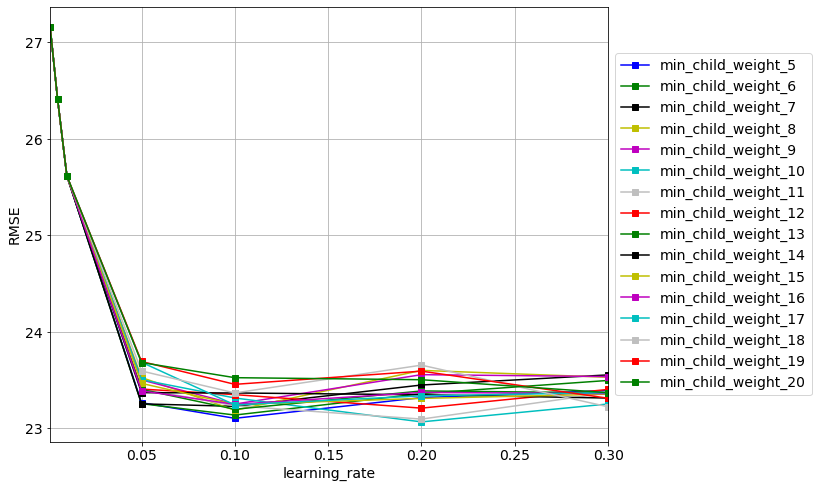

In [260]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [261]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 23.064
optimum params = 


(0.2, 10)

In [262]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.549%
optimum params = 


(0.05, 7)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [263]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,22.774329,0.554950
1,0.1,0.2,23.119855,0.560526
2,0.1,0.3,22.380868,0.544322
3,0.1,0.4,22.358048,0.543846
4,0.1,0.5,22.534883,0.547115
...,...,...,...,...
95,1.0,0.6,22.904098,0.556640
96,1.0,0.7,22.587869,0.548578
97,1.0,0.8,22.829953,0.557647
98,1.0,0.9,22.570326,0.549948


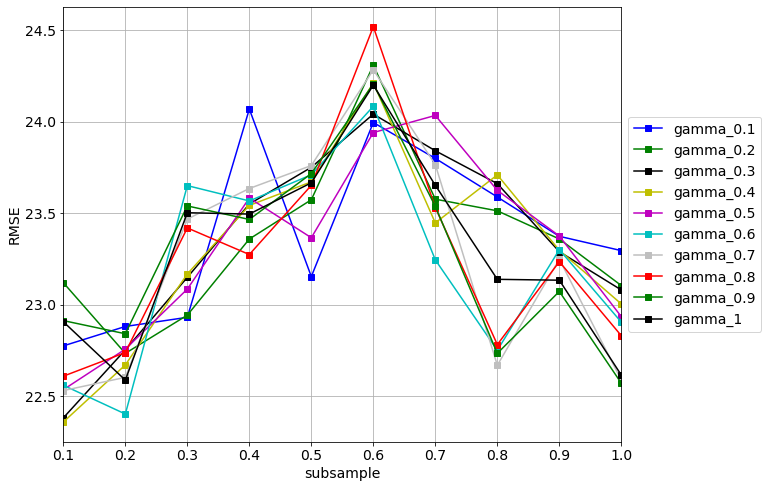

In [264]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [265]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 22.358
optimum params = 


(0.1, 0.4)

In [266]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.544%
optimum params = 


(0.2, 0.6)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [267]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,25.347553,0.638587
1,0.5,0.6,25.347553,0.638587
2,0.5,0.7,25.902070,0.654449
3,0.5,0.8,25.902070,0.654449
4,0.5,0.9,25.469597,0.632454
5,0.5,1.0,25.690335,0.641035
6,0.6,0.5,25.270255,0.633918
7,0.6,0.6,26.585428,0.671711
8,0.6,0.7,26.585428,0.671711
9,0.6,0.8,25.056792,0.627348


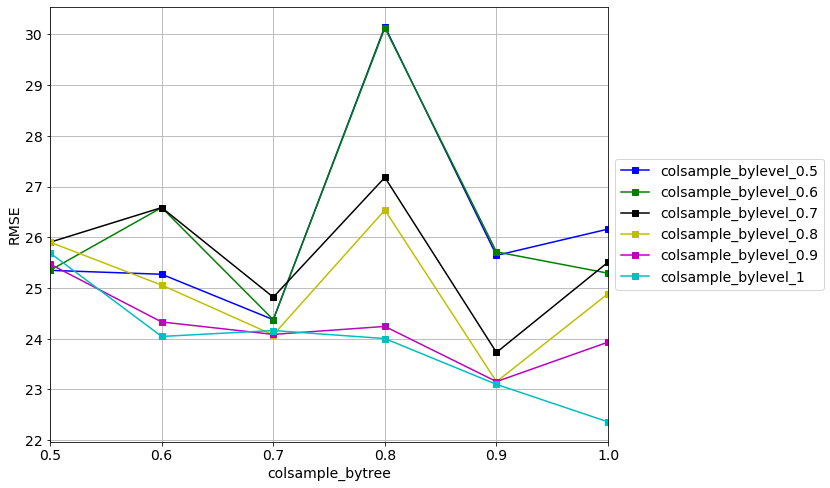

In [268]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [269]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 22.358
optimum params = 


(1.0, 1.0)

In [270]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.544%
optimum params = 


(1.0, 1.0)

# Tuned params

In [271]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,20.000
1,max_depth,3.000,5.000
2,learning_rate,0.100,0.200
3,min_child_weight,1.000,10.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.400
8,rmse,22.882,22.358
9,mape_pct,0.554,0.544


# Final model

In [272]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[21:43:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 45.591
MAPE on test set = 0.897%


Text(0, 0.5, 'USD')

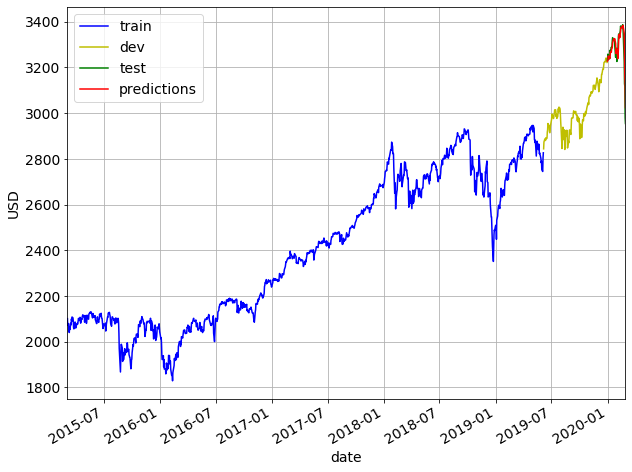

In [273]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

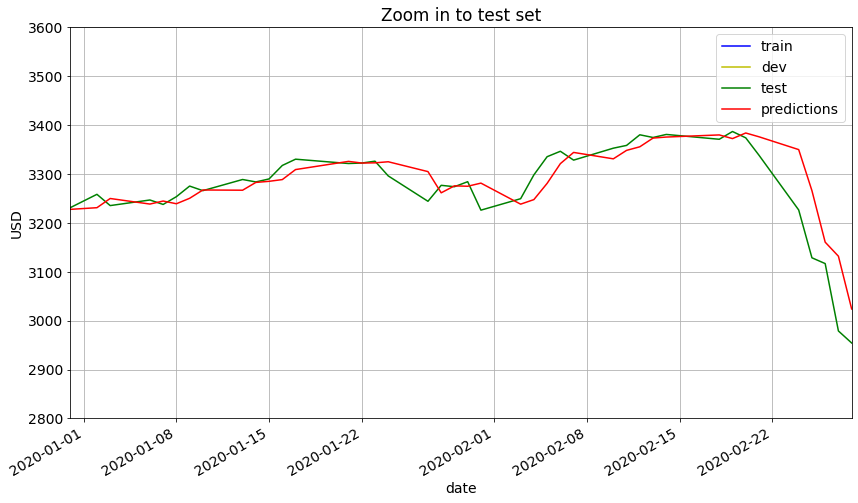

In [282]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 14, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 12, 31), date(2020, 2, 28)])
ax.set_ylim([2800, 3600])
ax.set_title("Zoom in to test set")

(2800, 3600)

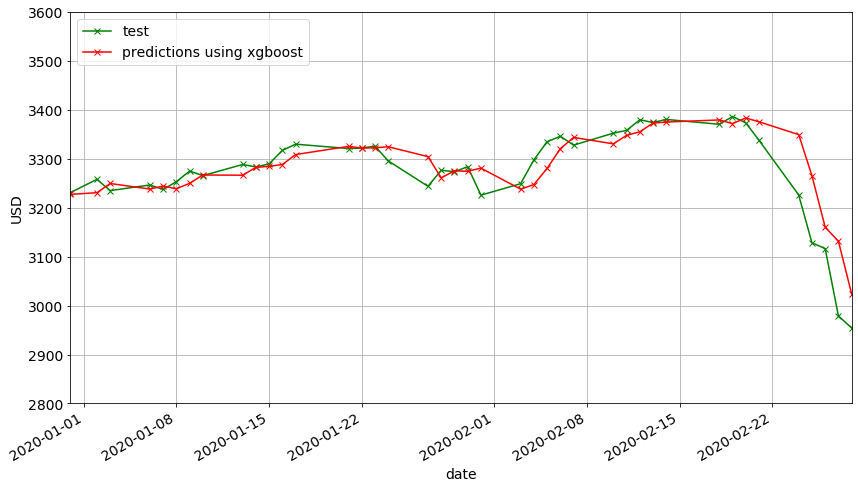

In [281]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 14, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 12, 31), date(2020, 2, 28)])
ax.set_ylim([2800, 3600])

In [335]:
est_df

,est,y_sample,date
1218,3227.154976,3230.780029,2019-12-31
1219,3230.534874,3257.850098,2020-01-02
1220,3249.335394,3234.850098,2020-01-03
1221,3237.962210,3246.280029,2020-01-06
1222,3244.121211,3237.179932,2020-01-07
1223,3238.594312,3253.050049,2020-01-08
1224,3249.737677,3274.699951,2020-01-09
1225,3266.708938,3265.350098,2020-01-10
1226,3266.249242,3288.129883,2020-01-13
1227,3282.148475,3283.149902,2020-01-14


In [322]:
est_df.iloc[1,2]

Timestamp('2020-01-02 00:00:00')

In [473]:
ret =np.empty(est_df.shape[0])
signal=0
for i in range(1,est_df.shape[0]):
    price_diff = est_df.iloc[i,1]-est_df.iloc[i-1,1]
    if est_df.iloc[i,0] > est_df.iloc[i-1,0]+1:  # predict price increase=> buy
        #print(i,'>',est_df.iloc[i,0], est_df.iloc[i-1,0],price_diff)
        signal = 1
    elif est_df.iloc[i,0]< est_df.iloc[i-1,0]-17:  # predict price decrease=> sell
        #print(i,'<',est_df.iloc[i,0], est_df.iloc[i-1,0],price_diff)
        if signal == 1:
            signal = -1
        else:
            signal=0
        
    ret[i] = signal*price_diff

In [474]:
ret=np.cumsum(ret)

In [475]:
ret=pd.DataFrame(ret)
ret['date']=np.array(est_df['date'])
ret.columns = ['return', 'date']
ret.loc[:, 'date'] = pd.to_datetime(ret['date'],format='%Y-%m-%d')
ret=ret.iloc[1:,]
ret.head()

,return,date
1,27.070068,2020-01-02
2,4.070068,2020-01-03
3,15.500000,2020-01-06
4,6.399902,2020-01-07
5,22.270020,2020-01-08


In [442]:
sample_diff = np.diff(est_df['y_sample'])
sample_diff=np.cumsum(sample_diff)
sample_diff=pd.DataFrame(sample_diff)
sample_diff['date']=np.array(est_df['date'].iloc[1:,])
sample_diff.columns = ['diff', 'date']
sample_diff.loc[:, 'date'] = pd.to_datetime(sample_diff['date'],format='%Y-%m-%d')
#=sample_diff.iloc[1:,]
sample_diff.head()

,diff,date
0,27.070068,2020-01-02
1,4.070068,2020-01-03
2,15.500000,2020-01-06
3,6.399902,2020-01-07
4,22.270020,2020-01-08


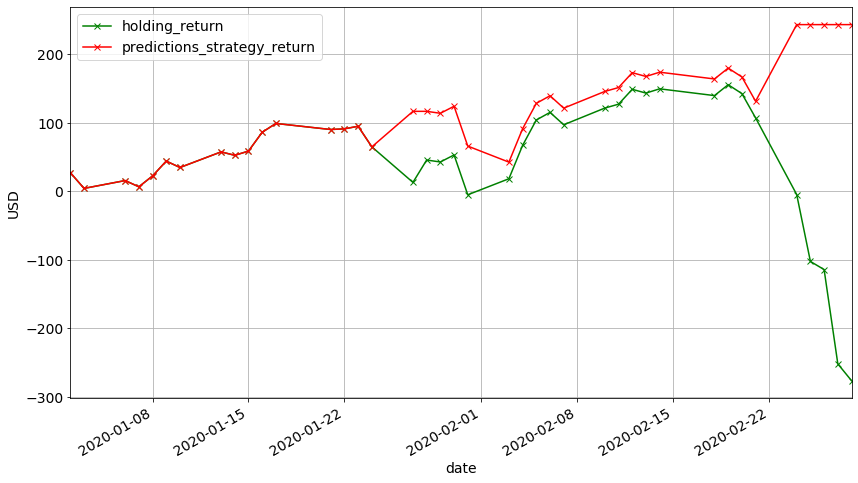

In [477]:
rcParams['figure.figsize'] = 14, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = sample_diff.plot(x='date', y='diff', style='gx-', grid=True)
ax = ret.plot(x='date', y='return', style='rx-', grid=True,ax=ax)
ax.legend(['holding_return', 'predictions_strategy_return'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
#ax.set_xlim([date(2019, 12, 31), date(2020, 2, 28)])
#ax.set_ylim([2800, 3600])
plt.show()